In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import control

H = np.array([[0, 8, 16], [1, 9, 17], [2, 10, 18], [3, 11, 19], [4, 12, 20]])
# print(H)


lst = np.array([[0], [1], [2], [3], [4]])

lambdachoice = np.array([[0, 1]])

lambdatimesG = np.linalg.pinv(lst) @ H

G = np.linalg.pinv(lambdachoice) @ lambdatimesG

# print(np.exp(H) - np.exp(lst @ lambdachoice @ G))

def linearSys(N, x0):
    '''Return data for N instances of linear system evolution'''
    A = np.array([[-0.99, -2, 3, 1], [0, 0.95, -1, 0.8], [0, 0, 0.96, -0.7], [0, 0, 0, -0.99]])/1.05
    
    
    C = np.zeros((1,4))
    C[0,0] = 1.0
    
    x = np.empty((4, N+1))
    x[:,0] = x0.flatten()
    y = np.empty((1, N+1))
    y[:,0] = C @ x0
    
    for i in range(N):
        x[:,i+1] = A @ x[:,i]
        y[:,i+1] = C @ x[:,i+1]
        
        
    # print(np.linalg.matrix_rank(control.obsv(A, C)))
    print(np.linalg.eigvals(A))
    return y
x0 = np.array([[10],[-3], [5], [2]]) 

print(linearSys(10, x0))

[-0.94285714  0.9047619   0.91428571 -0.94285714]
[[10.         12.47619048  7.03038549 25.98398445  3.67797294 35.51927188
   0.25280159 41.96615301 -3.03696435 46.02755038 -6.0588029 ]]


In [3]:
# Test MUSIC algorithm, originating as a source-finding algorithm for multiple independent frequence sources

N = 101
x0 = np.array([[10],[-3], [5], [2]]) 

H = linearSys(N, x0).T
# print(H)

# Compute auto-correlation matrix and eigendecomposition
Rx = H @ H.T
w, v = np.linalg.eig(Rx)
# Assume 4 sources
N_g = 4

idx = w.argsort()[::-1]
# print(w)
eig_sorted = w[idx]
vec_sorted = v[:, idx]

# Compute error matrix using noise eigenvectors
En = vec_sorted[:,N_g:]

def A_lambda(exponent):
    return np.vander(np.array([np.exp(exponent)]), N+1, increasing=True).T

# A_lambda = lambda lam : np.vander(np.array([np.exp(lam)]), N+1, increasing=True).T
P = lambda lam : 1 / (A_lambda(lam).conj().T @ En @ En.conj().T @ A_lambda(lam)).real

[-0.94285714  0.9047619   0.91428571 -0.94285714]


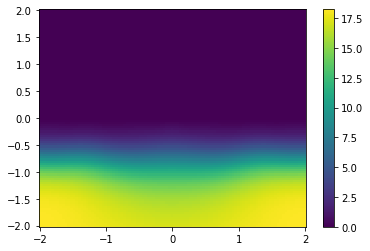

In [120]:
import matplotlib.pyplot as plt

# print(A_lambda(np.array([0,1])))

# Generate data
x = np.linspace(-2, 2, N)
y = x.copy()
X,Y = np.meshgrid(x,y)

Z = np.empty((N,N), dtype=complex)
for i in range(N):
    for k in range(N):
        Z[i,k] = P(x[i] + y[k]*1j)

cs = plt.pcolor(X,Y,np.absolute(Z))
plt.colorbar(cs)
plt.show()

In [4]:
import utils
N = 500
N_t = 10
H = np.empty((N+1, N_t))
n = 4
for i in range(N_t):
    H[:,i] = linearSys(N, np.random.rand(4))

U, S, V = np.linalg.svd(H, full_matrices=False)

# Estimate of eigenvalues using individual trajectories
print(S[:n])

# Estimate using time-delay coordinates
# H_test = np.array([[1, 2, 3,4, 5, 6, 7]])

H_test = H[:,0].reshape((1,N+1))
H_test_comp = utils.MakeHankelMatrix(H_test, 8)
H_test2 = H[:,1].reshape((1,N+1))
h_test_comp2 = utils.MakeHankelMatrix(H_test2, 8)

U2, S2, _ = np.linalg.svd(H_test_comp, full_matrices=False)
print(S2[:n])

U3, S3, _ = np.linalg.svd(h_test_comp2, full_matrices=False)

print(U[0,:n])
print(U2[0,:n])


print("Evolution matrices")

print( np.linalg.pinv(U[:N-1, :n]) @ U[1: N, :n])
print( np.linalg.pinv(U2[:7, :n]) @ U2[1: 8, :n])

s, _ = np.linalg.eig( np.linalg.pinv(U[:N-1, :n]) @ U[1: N, :n])#, full_matrices = False ) 
s2, _ = np.linalg.eig( np.linalg.pinv(U2[:7, :n]) @ U2[1: 8, :n])#, full_matrices = False ) 
s3, _ = np.linalg.eig( np.linalg.pinv(U3[:7, :n]) @ U3[1: 8, :n])#, full_matrices = False ) 
print(s)
print(s2)
print(s3)
V = np.vander(s, N+1, increasing=True).T

G = np.linalg.pinv(V) @ H

# Regularised Least squares
rho = 1
G_reg = np.linalg.inv(V.T @ V + rho * np.eye(4)) @ V.T @ H
print(V.shape)
print(G.shape)

print("Estimate for G")
print(G_reg)

print("Difference between measurement sequence and vandermonde estimate")
print(np.mean(H - V @ G))
print(np.mean(H - V @ G_reg))

[-0.94285714  0.9047619   0.91428571 -0.94285714]
[-0.94285714  0.9047619   0.91428571 -0.94285714]
[-0.94285714  0.9047619   0.91428571 -0.94285714]
[-0.94285714  0.9047619   0.91428571 -0.94285714]
[-0.94285714  0.9047619   0.91428571 -0.94285714]
[-0.94285714  0.9047619   0.91428571 -0.94285714]
[-0.94285714  0.9047619   0.91428571 -0.94285714]
[-0.94285714  0.9047619   0.91428571 -0.94285714]
[-0.94285714  0.9047619   0.91428571 -0.94285714]
[-0.94285714  0.9047619   0.91428571 -0.94285714]
[125.51100878  29.53834853   2.70655953   0.57117158]
[65.55930394 43.96258182  6.68675853  5.00213131]
[-0.01524615  0.02277216  0.19055771  0.64974027]
[-0.35838379 -0.28326757 -0.66313259  0.25718265]
Evolution matrices
[[-0.93718094 -0.34219503  0.02377018  0.03937922]
 [-0.34102972  0.93387846  0.08852242 -0.06088684]
 [-0.0707035   0.00845707 -0.65343895 -0.47369971]
 [-0.01261697  0.10091332 -0.72684528  0.59007477]]
[[-0.96624972  0.36531389  0.31140939  0.18534122]
 [ 0.15335956  0.9560

In [46]:
import methods
import Dictionaries
def linearSysFull(N, x0):
    '''Return data for N instances of linear system evolution'''
    A = np.array([[-0.99, -2, 3, 1], [0, 0.95, -1, 0.8], [0, 0, 0.96, -0.7], [0, 0, 0, -0.99]])/1.05
    
    
    C = np.zeros((1,4))
    C[0,0] = 1.0
    
    x = np.empty((4, N+1))
    x[:,0] = x0.flatten()
    y = np.empty((1, N+1))
    y[:,0] = C @ x0
    
    for i in range(N):
        x[:,i+1] = A @ x[:,i]
        y[:,i+1] = C @ x[:,i+1]
        
    return x


N = 500
N_t = 100
n = 4
H = np.empty((N_t, n, N))
for i in range(N_t):
    H[i,...] = linearSysFull(N-1, np.random.rand(4))

f = Dictionaries.monomial_dictionary(n, 5)

A, C, lift_fun = methods.compute_Korda2020(H, 10, f)
x0 = numpy.array([0.5,0.5])
B = numpy.zeros((f.size, 1))
u = numpy.zeros(

t_out, y_est, y_comp, y_est2 = methods.linear_compare(A, 

Computing linear evolution in data to find eigenvalues and eigenfunctions on nonrecurrent set
Computed eigenfunction, eigenvalue pairs in 57.7 ms
Applying function dictionary on trajectory data
Starting computation of linear evolution surface from data
Computed eigenfunction surface in 2852.9 ms
[[ 1.05025087e-01+1.00670567e-17j -4.61196594e-02+9.38704133e-18j
  -8.91509289e-02-2.24431108e-17j ...  2.17562741e-04-6.92294960e-20j
  -1.54621912e-03-8.04051979e-19j -1.20329911e-04+1.30097151e-20j]
 [-4.04484331e-02-1.86336219e-17j  1.58301211e-02-2.78008360e-17j
   3.67549510e-02+4.86223877e-17j ... -4.79975972e-05+2.04980657e-19j
   1.02420781e-03+1.81172607e-18j -1.00943500e-04-6.35258796e-20j]
 [-1.32840538e-02+3.77029856e-17j -1.48127875e-02-4.88423031e-17j
  -2.04258636e-03-3.28601568e-17j ... -1.27088827e-05+2.86190152e-20j
   1.47070056e-05-2.35241853e-20j  9.23679444e-06-1.38572061e-21j]
 ...
 [-6.63316328e-05+5.37415500e-05j -1.01210371e-05-3.60144252e-05j
   1.75875812e-05-1.515

In [99]:
import System
def randomCirc(N, n, r = 0.05):
    '''Construct N initial conditions for random points on an n-d sphere of radius r'''
    # Normalised n-d Gaussian points result in a uniform point on a sphere
    
    random_Initialconditions = np.random.randn(N,n)
    return r * random_Initialconditions / np.linalg.norm(random_Initialconditions, axis=1).reshape((N,1))


KordaEquation = System.differentialEquation(System.forcedvanDerPolSystemKorda, 2, 1)
Korda = System.System(KordaEquation, 'testdata/Korda2020.mat', 500, 150, 0.01, Generate=False, Autonomous=True, Initialisation_function = randomCirc)

X = Korda.trainingData()
f = Dictionaries.thin_plate_rbf_dictionary(2, 100, 2)

Key 'Generate' not found in system construction
Key 'Autonomous' not found in system construction
Using existing dataset at filepath
100


In [98]:
A, C, f_opt = methods.compute_Korda2020(X, 10, f)

Computing linear evolution in data to find eigenvalues and eigenfunctions on nonrecurrent set
Computed eigenfunction, eigenvalue pairs in 35.5 ms
Applying function dictionary on trajectory data
Starting computation of linear evolution surface from data
Computed eigenfunction surface in 1250.0 ms


(20, 20)
(2, 20)
(20, 102)
20
1


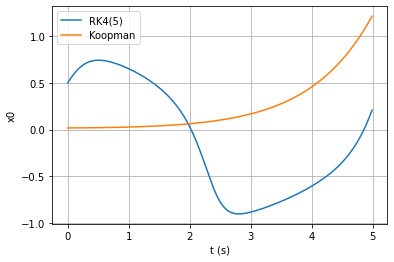

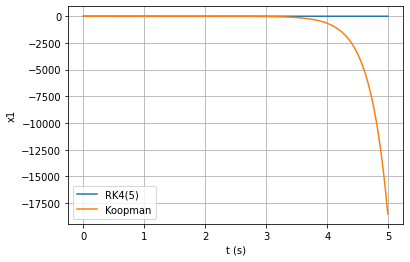

In [97]:
import plot_data
x0 = np.array([0.5, 0.5])
u = np.zeros((1,500))
B = np.zeros((20, 1))

t_out, y_est, y_comp, y_est2 = methods.linear_compare(A, B, C, Korda, f_opt, 0, x0, u)

plot_data.compareTrajectories(t_out, y_comp, y_est2, Names=["RK4(5)", "Koopman"])